## This notebook aims to use the best parameters to ensemble multiple models to generate the final scores.


In [1]:
valid_sparse_feat_addr = './features/sparse_features/annotation_data_0522.sparse.feat.undup'#.undup
test_sparse_feat_addr = './features/sparse_features/wsdm_test_2_all.sparse.feat.undup'

In [2]:
def get_bert_feat_addr(model_index, data_type):
    prefix = 'validation.' if data_type == 'valid' else ''
    addr = f'./features/bert_features/model{model_index}/{prefix}result.csv'
    return addr

In [3]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pandas import DataFrame
from collections import defaultdict

In [4]:
def load_as_csv(data_addr, size, with_label=True):
    data = {'label':[], 'qid':[] }
    data.update({f'f{i+1}':[] for i in range(size)})
    for line in tqdm(open(data_addr)):
        splits = line.strip().split()
        label = splits[0]
        qid = splits[1].split(':')[1]
        data['label'].append(int(label))
        data['qid'].append(int(qid))
        for i,f in list(map(lambda s:s.split(':'), splits[2:])):
            data[f'f{i}'].append(float(f))

    return DataFrame(data)
            
    

In [5]:
def get_merge_feat_csv(sparse_feat_addr, *args):
    data = [[] for i in range(len(args))]
    for i,addr in enumerate(args):
        for line in open(addr):
            data[i].append(float(line.strip()))

    df = defaultdict(list)
    df.update({f'f{i+1}':[] for i in range(6)})
    for i,line in enumerate(open(sparse_feat_addr)):
        splits = line.strip().split()
        label = splits[0]
        qid = splits[1].split(':')[1]
        if '.' in qid:
            print(splits)
            break
        df['label'].append(int(label))
        df['qid'].append(int(qid))
        for j,f in list(map(lambda s:s.split(':'), splits[2:])):
            df[f'f{j}'].append(float(f))
        for idx in range(len(data)):
            df[f'f{6 + idx + 1}'].append(data[idx][i])
    return DataFrame(df)
    
                              

In [6]:
feat_addrs = [get_bert_feat_addr(i, 'valid') for i in [1,2,3,4,6]]
all_data_df = get_merge_feat_csv(valid_sparse_feat_addr,*feat_addrs)

In [7]:
import lightgbm

def prepare_data(df):
    qids_group = df.groupby("qid")["qid"].count().to_numpy()
    X_train = df.drop(["qid", "label"], axis = 1)
    # Relevance label for train
    y_train = df['label'].astype(int)
    return X_train, y_train, qids_group


In [8]:
final_x_train, final_y_train, final_qids_groups = prepare_data(all_data_df)

In [9]:
ranker = lightgbm.LGBMRanker(
                    objective="lambdarank",
                    boosting_type = "gbdt",
                    n_estimators = 100,
                    importance_type = "gain",
                    metric= "ndcg",
                    num_leaves = 10,
                    learning_rate = 0.05,
                    max_depth = -1,)#If random_state is None, default seeds in C++ code are used.
ranker.fit(
      X=final_x_train,
      y=final_y_train,
      group=final_qids_groups,
      eval_set=[(final_x_train, final_y_train),],
      eval_group=[final_qids_groups, ],
      eval_at=[10])

[1]	training's ndcg@10: 0.733475
[2]	training's ndcg@10: 0.78221
[3]	training's ndcg@10: 0.787102
[4]	training's ndcg@10: 0.792092
[5]	training's ndcg@10: 0.79305
[6]	training's ndcg@10: 0.794052
[7]	training's ndcg@10: 0.795837
[8]	training's ndcg@10: 0.796309
[9]	training's ndcg@10: 0.796617
[10]	training's ndcg@10: 0.797144
[11]	training's ndcg@10: 0.797554
[12]	training's ndcg@10: 0.797483
[13]	training's ndcg@10: 0.797929
[14]	training's ndcg@10: 0.797977
[15]	training's ndcg@10: 0.797987
[16]	training's ndcg@10: 0.798464
[17]	training's ndcg@10: 0.798998
[18]	training's ndcg@10: 0.798595
[19]	training's ndcg@10: 0.799123
[20]	training's ndcg@10: 0.799007
[21]	training's ndcg@10: 0.799397
[22]	training's ndcg@10: 0.799296
[23]	training's ndcg@10: 0.799203
[24]	training's ndcg@10: 0.799111
[25]	training's ndcg@10: 0.799334
[26]	training's ndcg@10: 0.799282
[27]	training's ndcg@10: 0.799249
[28]	training's ndcg@10: 0.799517
[29]	training's ndcg@10: 0.799478
[30]	training's ndcg@10: 

LGBMRanker(importance_type='gain', learning_rate=0.05, metric='ndcg',
           num_leaves=10, objective='lambdarank')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

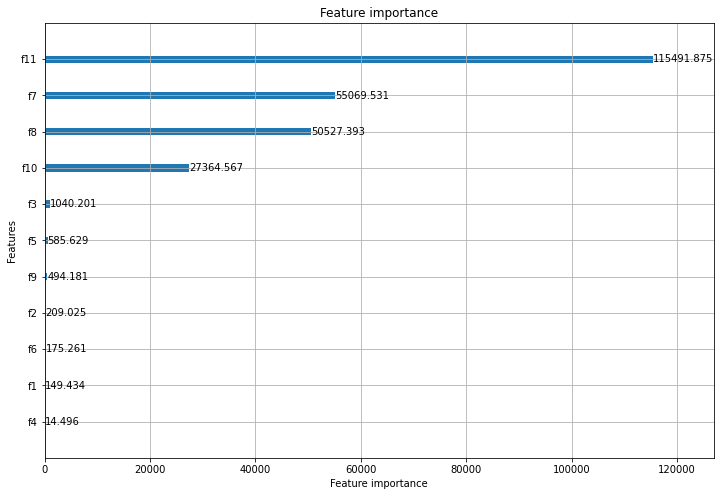

In [10]:
lightgbm.plot_importance(ranker, figsize = (12,8))

In [12]:
feat_addrs = [get_bert_feat_addr(i, 'test') for i in [1,2,3,4,6]]
all_test_data_df = get_merge_feat_csv(test_sparse_feat_addr,*feat_addrs)

In [14]:
final_x_test, final_y_test, final_test_qids_groups = prepare_data(all_test_data_df)

In [15]:
scores = ranker.predict(final_x_test)

In [18]:
with open('./features/final_result.csv', 'w') as fout:
    for s in scores:
        fout.write(f"{s}\n")

In [19]:
scores

array([ 1.80103392, -3.95720269, -2.45329216, ...,  0.74541848,
        0.76744129,  0.07373201])